# MSDS 7331 - Mini-Project: SVM&LR Classification
## Team: Dineen Parker, Dale Legband, Ryan Shuhart
collaboration site: https://github.com/rlshuhart/MSDS7331_Mini-Lab

### Log to capture iterations of findings and ideas for feature selection and analysis

1. First attempt of logistic model revealed need to one-hot encode categorical variables
2. After numerically encoding categorical variables, the logistic model more or less predicted all to not default.
3. Changeing penalty on logistic model from l2 to l1 improved the model by about 3 percentage points.
4. Changing class_weight='balanced' negatively impacted model
5. Changing C to 100 had no impact
6. Changing C to .0001 had small negative impact
7. Reviewed logistic coefficients on scaled data and it appears the most recent pay status (PAY_0_Sept), the most recent two bill amounts ('BILL_AMT1_Sept', 'BILL_AMT2_Aug'), the most recent two payment amounts are the highest predictors ('PAY_AMT1_Sept', 'PAY_AMT2_Aug').

## SVM and Logistic Regression Modeling  
* [50 points] Create a logistic regression model and a support vector machine model for the classiﬁcation task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is ﬁne to use. 
* [10 points] Discuss the advantages of each model for each classiﬁcation task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efﬁciency? Explain in detail.  
* [30 points] Use the weights from logistic regression to interpret the importance of different features for each classiﬁcation task. Explain your interpretation in detail. Why do you think some variables are more important? 
* [10 points] Look at the chosen support vectors for the classiﬁcation task. Do these provide any insight into the data? Explain

In [1]:
### Modules Used ###

# Data manipulation: pandas and numpy
import pandas as pd
import numpy as np

# Visualization: seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Read in preprocessed data from previous assignment

In [2]:
# Random but useful fact: if the first record in a csv file is 
# "ID" than Excel will interpret it as a SYLK file
# https://annalear.ca/2010/06/10/why-excel-thinks-your-csv-is-a-sylk/

data_url = "https://raw.githubusercontent.com/rlshuhart/MSDS7331_Project_1/master/cc_data/cc_data_processed.csv"
#data_url = "../MSDS7331_Project_1/cc_data/cc_data_processed.csv"

cc_data = pd.read_csv(data_url, index_col='ID')

In [3]:
print(cc_data.info())
print()
print(cc_data.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 27 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null object
EDUCATION                     30000 non-null object
MARRIAGE                      30000 non-null object
AGE                           30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept        

# Additional Preprocessing of data

### One hot encoding of categorical variables

In [4]:
# makeing copy of data to retain original input for now. 
# Have to add .copy() or any change will reflect in the original too.
cc_data_processed = cc_data.copy()

cats = ['SEX', 'EDUCATION', 'MARRIAGE','AGE_range', 'LIMIT_BAL_range']

# SEX convert to isMale
cc_data_processed['isMale'] = cc_data['SEX']=='Male'

# Two options for Education: 
# If treating ordinal then keep single columnn but label in numerical order
# if nominal then create dummy variables.
# Trying ordinal first with 'Others' as the highest. Previous exploration
# showed this group have better rates of default which continued the trend
# of more education means less likely to default:
cc_data_processed['EDUCATION'] = cc_data['EDUCATION'].apply({'High School':0,
                                                             'University':1,
                                                             'Graduate School':2, 
                                                             'Others':3}.get)

# Marriage is nominal category therefore converting to dummies

cc_data_processed = pd.concat((cc_data_processed, 
                               pd.get_dummies(cc_data['MARRIAGE'], prefix='Marriage')), 
                               axis=1)

# Age range is ordinal category:
cc_data_processed['AGE_range'] = cc_data['AGE_range'].apply({'21-30':0,
                                                             '31-40':1,
                                                             '41-50':2, 
                                                             '51-60':3,
                                                             '61-70':4,
                                                             '71-80+':5}.get)
# Limit_Bal_Range is ordingal
cc_data_processed['LIMIT_BAL_range'] = cc_data['LIMIT_BAL_range'].apply({'0-250k':0,
                                                                         '>250k-500k':1,
                                                                         '>500k-750k':2,
                                                                         '>750k':3}.get)

# Drop unused features:
# 'Default_Yes_No' - Used for visualization labeling only and same as 'default payment next month'
# 'AGE' - Using Age_range instead, may bring back
cc_data_processed.drop(['Default_Yes_No','AGE', 'SEX','MARRIAGE', 'LIMIT_BAL'], axis=1, inplace=True)

print(cc_data_processed.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 26 columns):
EDUCATION                     30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept                 30000 non-null int64
PAY_AMT2_Aug                  30000 non-null int64
PAY_AMT3_July                 30000 non-null int64
PAY_AMT4_June                 30000 non-null int64
PAY_AMT5_May            

### Convert data to numpy arrays

In [5]:
cc_data_target = cc_data_processed['default payment next month'].values
cc_data_Xs = cc_data_processed.drop('default payment next month', axis='columns').values
cc_data_Xs_names = cc_data_processed.drop('default payment next month', axis='columns').columns

# Prediction Models

In [6]:
# Scikit Modules
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler

In [7]:
# Sample Default Rate
sample_d_rt = (1 - cc_data_target.sum() / len(cc_data_target))*100
print("The sample default rate is: %.1f%%"  % sample_d_rt)

# The sample default rate is the same as predicting all zeros (or no defaults)
all_zeros = np.zeros(len(cc_data_target))
all_zero_score = mt.accuracy_score(cc_data_target,all_zeros)*100
print("The models should have an accuracy better than predicting all non-defaults of %.1f%%"  % all_zero_score)

The sample default rate is: 77.9%
The models should have an accuracy better than predicting all non-defaults of 77.9%


## Logistic Regression

#### Review of different parameters

In [23]:
def classify(model, X, y):
    accuracies = cross_val_score(model,X,y=y)
    predicted = cross_val_predict(model,X,y=y)
    print(accuracies)
    return(predicted)

In [24]:
model = LogisticRegression(penalty='l2', C=1.0, class_weight=None)
p = classify(model, cc_data_Xs, cc_data_target)

#below compares how close to all zero prediction
print("Model predicts %.1f%% will not default" % (mt.accuracy_score(p,all_zeros)*100))

[ 0.7799  0.7827  0.7826]
Model predicts 99.3% will not default


In [9]:
# Changed penalty to 'l1'
model = LogisticRegression(penalty='l1', C=1.0, class_weight=None)
p = classify(model, cc_data_Xs, cc_data_target)

#below compares how close to all zero prediction
print("Model predicts %.1f%% will not default" % (mt.accuracy_score(p,all_zeros)*100))

[ 0.806   0.8136  0.8079]
Model predicts 92.6% will not default


In [10]:
# Changed class_weight to 'balanced'
model = LogisticRegression(penalty='l1', C=1.0, class_weight='balanced')
p = classify(model, cc_data_Xs, cc_data_target)

#below compares how close to all zero prediction
print("Model predicts %.1f%% will not default" % (mt.accuracy_score(p,all_zeros)*100))

[ 0.683   0.6775  0.7151]
Model predicts 63.3% will not default


In [11]:
# Increased C to 1000
model = LogisticRegression(penalty='l1', C=1000.0, class_weight=None)
p = classify(model, cc_data_Xs, cc_data_target)

#below compares how close to all zero prediction
print("Model predicts %.1f%% will not default" % (mt.accuracy_score(p,all_zeros)*100))

[ 0.806   0.8135  0.808 ]
Model predicts 92.6% will not default


In [12]:
# Decreased C to .001
model = LogisticRegression(penalty='l1', C=0.001, class_weight=None)
p = classify(model, cc_data_Xs, cc_data_target)

#below compares how close to all zero prediction
print("Model predicts %.1f%% will not default" % (mt.accuracy_score(p,all_zeros)*100))

[ 0.797   0.8051  0.797 ]
Model predicts 94.4% will not default


#### Find coefficients 

In [13]:
# Create Cross Validation object
num_cv_iterations = 3
num_instances = len(cc_data_target)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)

In [26]:
def full_classify(y, X, cv_object, model, scale=False):
    for iter_num, (train_indices, test_indices) in enumerate(cv_object):
        if scale == True:
            scl_obj = StandardScaler()
            scl_obj.fit(X[train_indices])
            X_train_scaled = scl_obj.transform(X[train_indices])
            X_test_scaled = scl_obj.transform(X[test_indices])
            model.fit(X_train_scaled,y[train_indices])
            y_hat = model.predict(X_test_scaled)
            print("SCALED DATA")
        elif scale == False:
            model.fit(X[train_indices],y[train_indices])  # train object
            y_hat = model.predict(X[test_indices]) # get test set precitions

        # print the accuracy and confusion matrix 
        print("\n====Iteration",iter_num," ====")
        print("accuracy", mt.accuracy_score(y[test_indices],y_hat) )
        print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))
        print("Classification Report:\n",mt.classification_report(y[test_indices],y_hat))
        print("ROC Score \n",mt.roc_auc_score(y[test_indices],y_hat))
        
    return model.coef_

# captures coeficients of last training set
coef = full_classify(cc_data_target, cc_data_Xs, cv_object, LogisticRegression(penalty='l1', C=1.0, class_weight=None))
coef_scaled = full_classify(cc_data_target, cc_data_Xs, cv_object, LogisticRegression(penalty='l1', C=1.0, class_weight=None), scale = True)


====Iteration 0  ====
accuracy 0.8075
confusion matrix
 [[4546  131]
 [1024  299]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4677
          1       0.70      0.23      0.34      1323

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.598996051988

====Iteration 1  ====
accuracy 0.814833333333
confusion matrix
 [[4562  118]
 [ 993  327]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4680
          1       0.73      0.25      0.37      1320

avg / total       0.80      0.81      0.78      6000

ROC Score 
 0.611256798757

====Iteration 2  ====
accuracy 0.812166666667
confusion matrix
 [[4573  129]
 [ 998  300]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4702
          1       0.70      0.23      0.35      1298

avg / total    

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 0  ====
accuracy 0.8155
confusion matrix
 [[4576  124]
 [ 983  317]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4700
          1       0.72      0.24      0.36      1300

avg / total       0.80      0.82      0.78      6000

ROC Score 
 0.608731587561


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 1  ====
accuracy 0.814333333333
confusion matrix
 [[4576  144]
 [ 970  310]]
Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.97      0.89      4720
          1       0.68      0.24      0.36      1280

avg / total       0.79      0.81      0.78      6000

ROC Score 
 0.605839512712


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 2  ====
accuracy 0.8035
confusion matrix
 [[4525  128]
 [1051  296]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.88      4653
          1       0.70      0.22      0.33      1347

avg / total       0.79      0.80      0.76      6000

ROC Score 
 0.596119226669


In [27]:
print("Coefficients and column names same length: " + str(len(coef_scaled.T)==len(cc_data_Xs_names)))
print()
# sort these attributes and spit them out
zip_vars = zip(coef_scaled.T,cc_data_Xs_names) # combine attributes
# zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

Coefficients and column names same length: True

EDUCATION has weight of -0.00667687909492
PAY_0_Sept has weight of 0.643400958366
PAY_2_Aug has weight of 0.0919917280247
PAY_3_July has weight of 0.105240012431
PAY_4_June has weight of 0.0201025522311
PAY_5_May has weight of 0.0700113650857
PAY_6_April has weight of 0.00942559245998
BILL_AMT1_Sept has weight of -0.291748774343
BILL_AMT2_Aug has weight of 0.0918856191507
BILL_AMT3_July has weight of 0.0
BILL_AMT4_June has weight of -0.000103688523831
BILL_AMT5_May has weight of 0.0599696995714
BILL_AMT6_April has weight of 0.0461725380135
PAY_AMT1_Sept has weight of -0.219836418089
PAY_AMT2_Aug has weight of -0.202853870693
PAY_AMT3_July has weight of -0.0633280609377
PAY_AMT4_June has weight of -0.0870449296481
PAY_AMT5_May has weight of -0.0696528639808
PAY_AMT6_April has weight of -0.0865251910586
AGE_range has weight of 0.0352096054843
LIMIT_BAL_range has weight of -0.034247523055
isMale has weight of 0.0738273373288
Marriage_Marrie

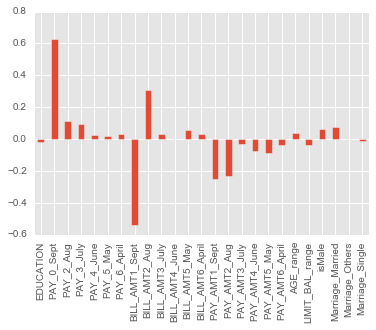

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(coef_scaled[0],index=cc_data_Xs_names)
weights.plot(kind='bar')
plt.show()

# Intrepretting weights

In [17]:
#Weights are not to scale 
weights = cc_data_Xs.T # <- this makes the columns to rows and rows to columns
#variable_names = cc_data.columns <- cc_data is the old data frame
variable_names = cc_data_processed.drop('default payment next month', axis='columns').columns
for coef, name in zip(weights,variable_names): # <- the zipping is 
    print(name, 'has weight of', coef[0])
    
print(cc_data_Xs[0])

EDUCATION has weight of 1
PAY_0_Sept has weight of 2
PAY_2_Aug has weight of 2
PAY_3_July has weight of -1
PAY_4_June has weight of -1
PAY_5_May has weight of -2
PAY_6_April has weight of -2
BILL_AMT1_Sept has weight of 3913
BILL_AMT2_Aug has weight of 3102
BILL_AMT3_July has weight of 689
BILL_AMT4_June has weight of 0
BILL_AMT5_May has weight of 0
BILL_AMT6_April has weight of 0
PAY_AMT1_Sept has weight of 0
PAY_AMT2_Aug has weight of 689
PAY_AMT3_July has weight of 0
PAY_AMT4_June has weight of 0
PAY_AMT5_May has weight of 0
PAY_AMT6_April has weight of 0
AGE_range has weight of 0
LIMIT_BAL_range has weight of 0
isMale has weight of False
Marriage_Married has weight of 1.0
Marriage_Others has weight of 0.0
Marriage_Single has weight of 0.0
[1 2 2 -1 -1 -2 -2 3913 3102 689 0 0 0 0 689 0 0 0 0 0 0 False 1.0 0.0 0.0]


In [18]:
#Weights are to scale 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scl_obj = StandardScaler()
scl_obj.fit(cc_data_Xs)
cc_data_Xs_scaled = scl_obj.transform(cc_data_Xs)

model = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

def classify(model, X,y):
    accuracies = cross_val_score(model,X,y=y) 
    print(accuracies)
classify(model, cc_data_Xs_scaled, cc_data_target)

#error, I think there is an error because of the boolean on PAY_AMT5_May*****************
## the accuracy changed but the weights didn't
zip_vars = zip(cc_data_Xs_scaled.T,cc_data_processed.columns) 
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0])



C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[ 0.8059  0.8134  0.808 ]
EDUCATION has weight of -0.302184120799
PAY_0_Sept has weight of 1.79456386405
PAY_2_Aug has weight of 1.78234817179
PAY_3_July has weight of -0.696663456339
PAY_4_June has weight of -0.66659873142
PAY_5_May has weight of -1.53004603493
PAY_6_April has weight of -1.48604075759
BILL_AMT1_Sept has weight of -0.642501072921
BILL_AMT2_Aug has weight of -0.647399230437
BILL_AMT3_July has weight of -0.6679933105
BILL_AMT4_June has weight of -0.67249726864
BILL_AMT5_May has weight of -0.663058531759
BILL_AMT6_April has weight of -0.652724218139
PAY_AMT1_Sept has weight of -0.341941618708
PAY_AMT2_Aug has weight of -0.227085635812
PAY_AMT3_July has weight of -0.296801274077
PAY_AMT4_June has weight of -0.308062561735
PAY_AMT5_May has weight of -0.31413611731
PAY_AMT6_April has weight of -0.293382057925
default payment next month has weight of -1.03700389227
AGE_range has weight of -0.526895077391
LIMIT_BAL_range has weight of -0.810160739624
isMale has weight of 1.093